In [1]:
from simple_foraging_env import SimpleForagingEnv
from opponent_model import OpponentModel, SubGoalSelector
from q_agent import QLearningAgent, ReplayBuffer
from q_agent_classic import QLearningAgentClassic
from omg_args import OMGArgs
import transformers as t
import matplotlib.pyplot as plt
import torch
import os

In [2]:
from experiments.om import q_agent


env = SimpleForagingEnv(grid_size=7, max_steps=30)

obs_sample = env.reset()[0]
H, W, F_dim = obs_sample.shape
NUM_ACTIONS = 4

args = OMGArgs(
  device="cpu",
  folder_id="0",
  batch_size=8,
  horizon_H=6,
  qnet_hidden=256,
  max_steps=30,
  selector_mode="conservative",
  vae_beta=0.1,
  beta_start=1.0,
  beta_end=2.0,
  selector_tau_start=2.0,
  selector_tau_end=0.1,
  state_shape=obs_sample.shape,
  H=H, W=W,
  state_feature_splits=(F_dim,),
  action_dim=NUM_ACTIONS,
  latent_dim=32,
  d_model=256,
  nhead=8,
  num_encoder_layers=2,
  num_decoder_layers=2,
  dim_feedforward=1024,
  dropout=0.1,
)

os.makedirs("./diagrams_0", exist_ok=True)

vae = t.TransformerVAE(args)
cvae = t.TransformerCVAE(args)
vae.load_state_dict(torch.load('./models_0/vae.pth', map_location=args.device))
cvae.load_state_dict(torch.load('./models_0/cvae.pth', map_location=args.device))
selector = SubGoalSelector(args)

op_model = OpponentModel(
  cvae, vae, selector, args=args)

q_agent = QLearningAgent(
    env=env,
    opponent_model=op_model,
    args=args
)
q_agent.q.load_state_dict(torch.load('./models_0/qnet.pth', map_location=args.device))

<All keys matched successfully>

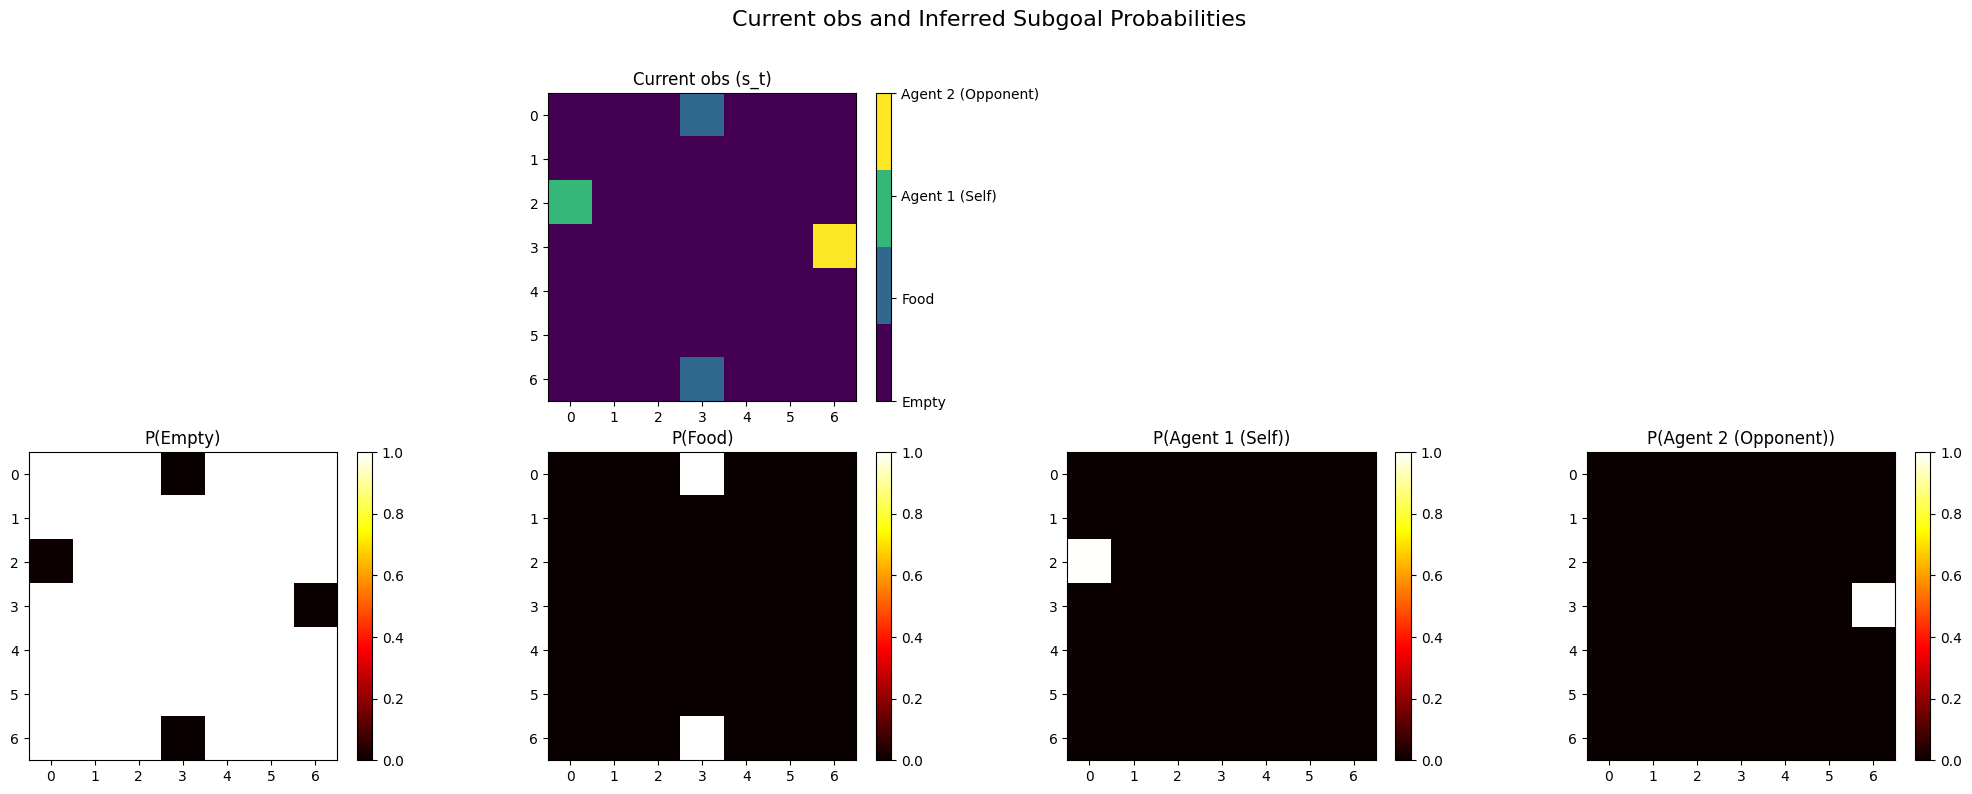

[ 0.01791443 -0.04856773  0.06838155 -0.00861046  0.01570305  0.04268112
  0.04607986  0.01356459 -0.02401157  0.02103832 -0.03813431  1.3682268
 -1.4290845  -0.0691494  -1.3565089  -0.08863793  0.02997997  0.01793324
 -0.20180385  0.00187443 -0.02273826  0.25476468  0.06501095 -0.0557542
  0.0068191  -0.05222398 -0.00248254  0.04955143 -0.03106052 -0.04972488
  0.0523633  -0.02594629]


In [13]:
env._place_agent(0, (2, 0))
obs = env._get_observations()
op_model.prior_model.eval()
recon_logits, mu, logvar = op_model.prior_model(
    torch.from_numpy(obs[0]).float().unsqueeze(0).to(args.device)
)
op_model.visualize_subgoal_logits(
    obs[0], recon_logits)
print(mu.squeeze(0).detach().cpu().numpy())

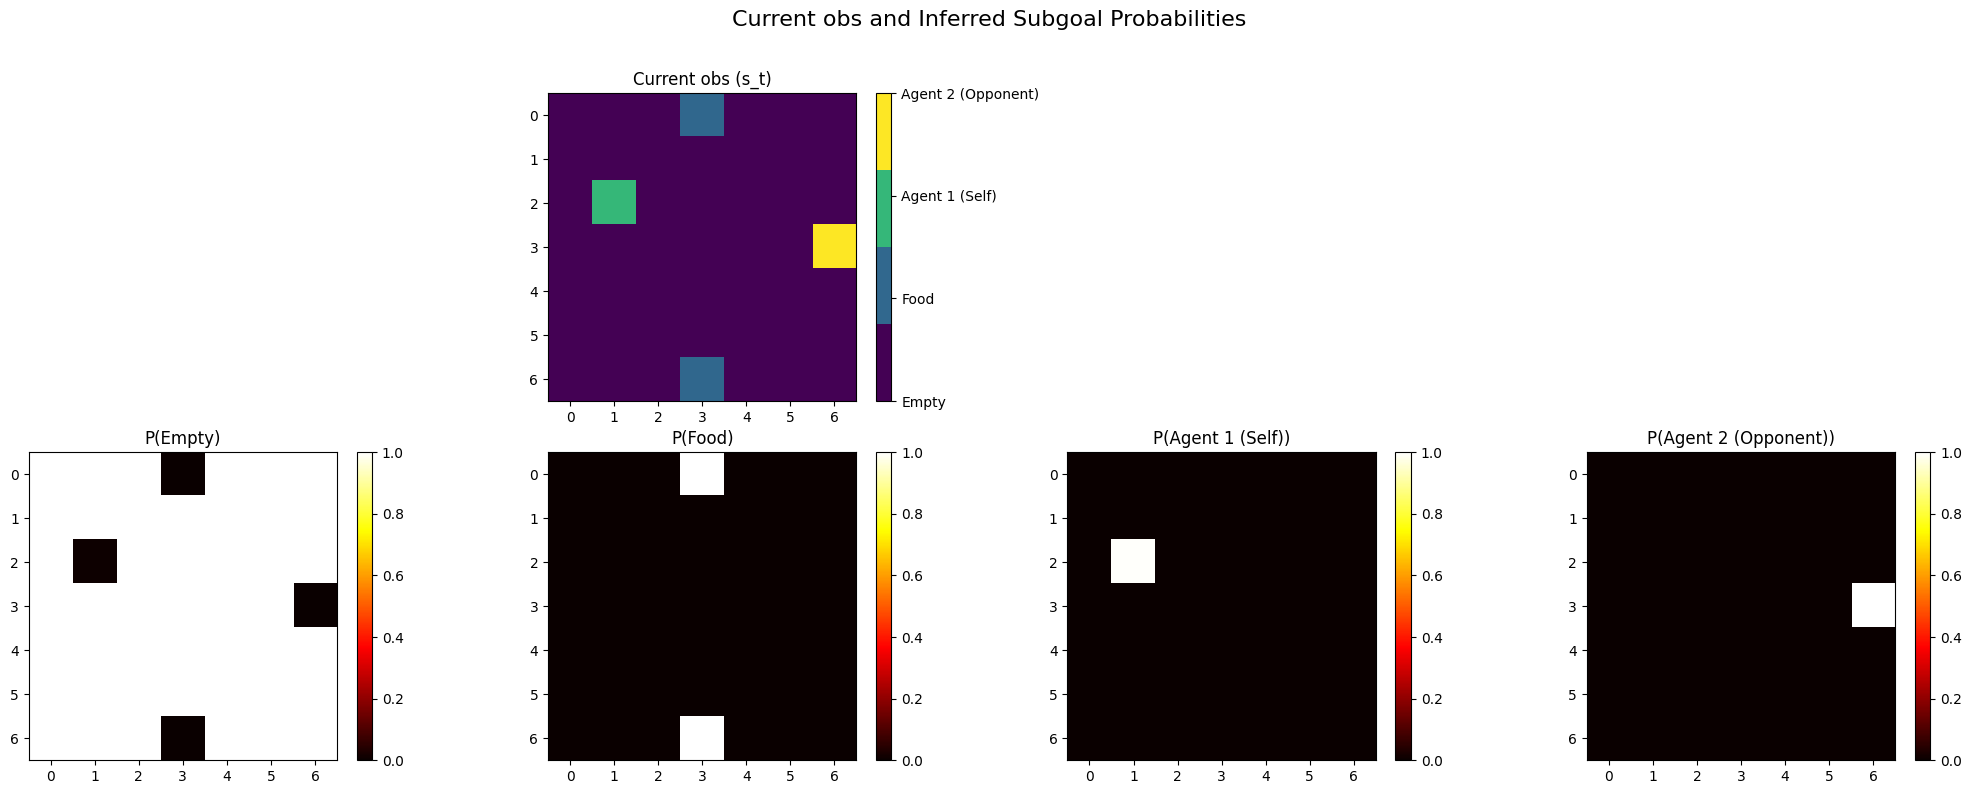

[ 0.03509206 -0.04888149  0.12806693  0.02355212 -0.00864409  0.02998334
  0.0095782   0.05945846 -0.04684768  0.01368807 -0.01465534  1.5340695
 -1.1181029  -0.0406015  -1.4796104  -0.04590072  0.00559146  0.02329228
 -0.23509146  0.01215787  0.00677167  0.1414704   0.07051013 -0.04025973
 -0.06013003 -0.0445334  -0.01336077 -0.00688136 -0.01936184 -0.03987476
  0.01349278 -0.01546827]


In [14]:
env._place_agent(0, (2, 1))
obs = env._get_observations()
op_model.prior_model.eval()
recon_logits, mu, logvar = op_model.prior_model(
    torch.from_numpy(obs[0]).float().unsqueeze(0).to(args.device)
)
op_model.visualize_subgoal_logits(
    obs[0], recon_logits)
print(mu.squeeze(0).detach().cpu().numpy())

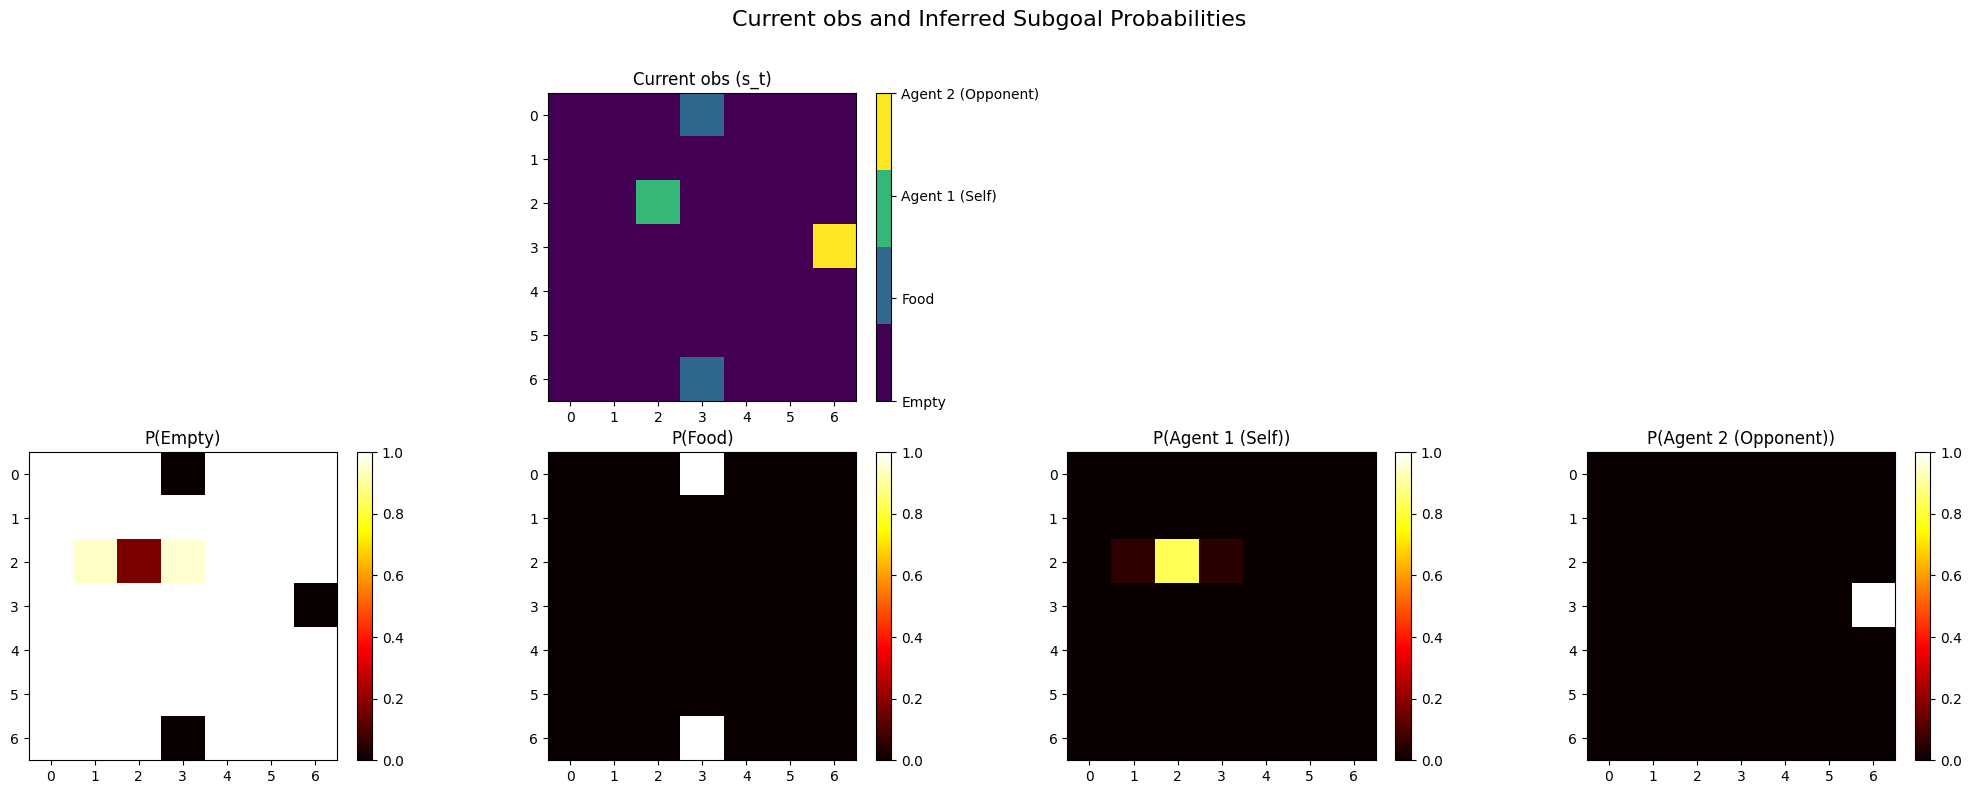

[ 0.04762094 -0.04262133  0.14022419  0.04000933 -0.01535701  0.00792807
  0.02430972  0.06986192 -0.06582694  0.00336754 -0.01296594  1.5742286
 -0.9511008  -0.03252444 -1.4943796  -0.03789249  0.00375648  0.00709744
 -0.16863865  0.03405285  0.00991043  0.11029038  0.07084701 -0.02774777
 -0.09540191 -0.03951    -0.01641638  0.01381284 -0.00837591 -0.0370706
 -0.01073113 -0.00374049]


In [15]:
env._place_agent(0, (2, 2))
obs = env._get_observations()
op_model.prior_model.eval()
recon_logits, mu, logvar = op_model.prior_model(
    torch.from_numpy(obs[0]).float().unsqueeze(0).to(args.device)
)
op_model.visualize_subgoal_logits(
    obs[0], recon_logits)
print(mu.squeeze(0).detach().cpu().numpy())

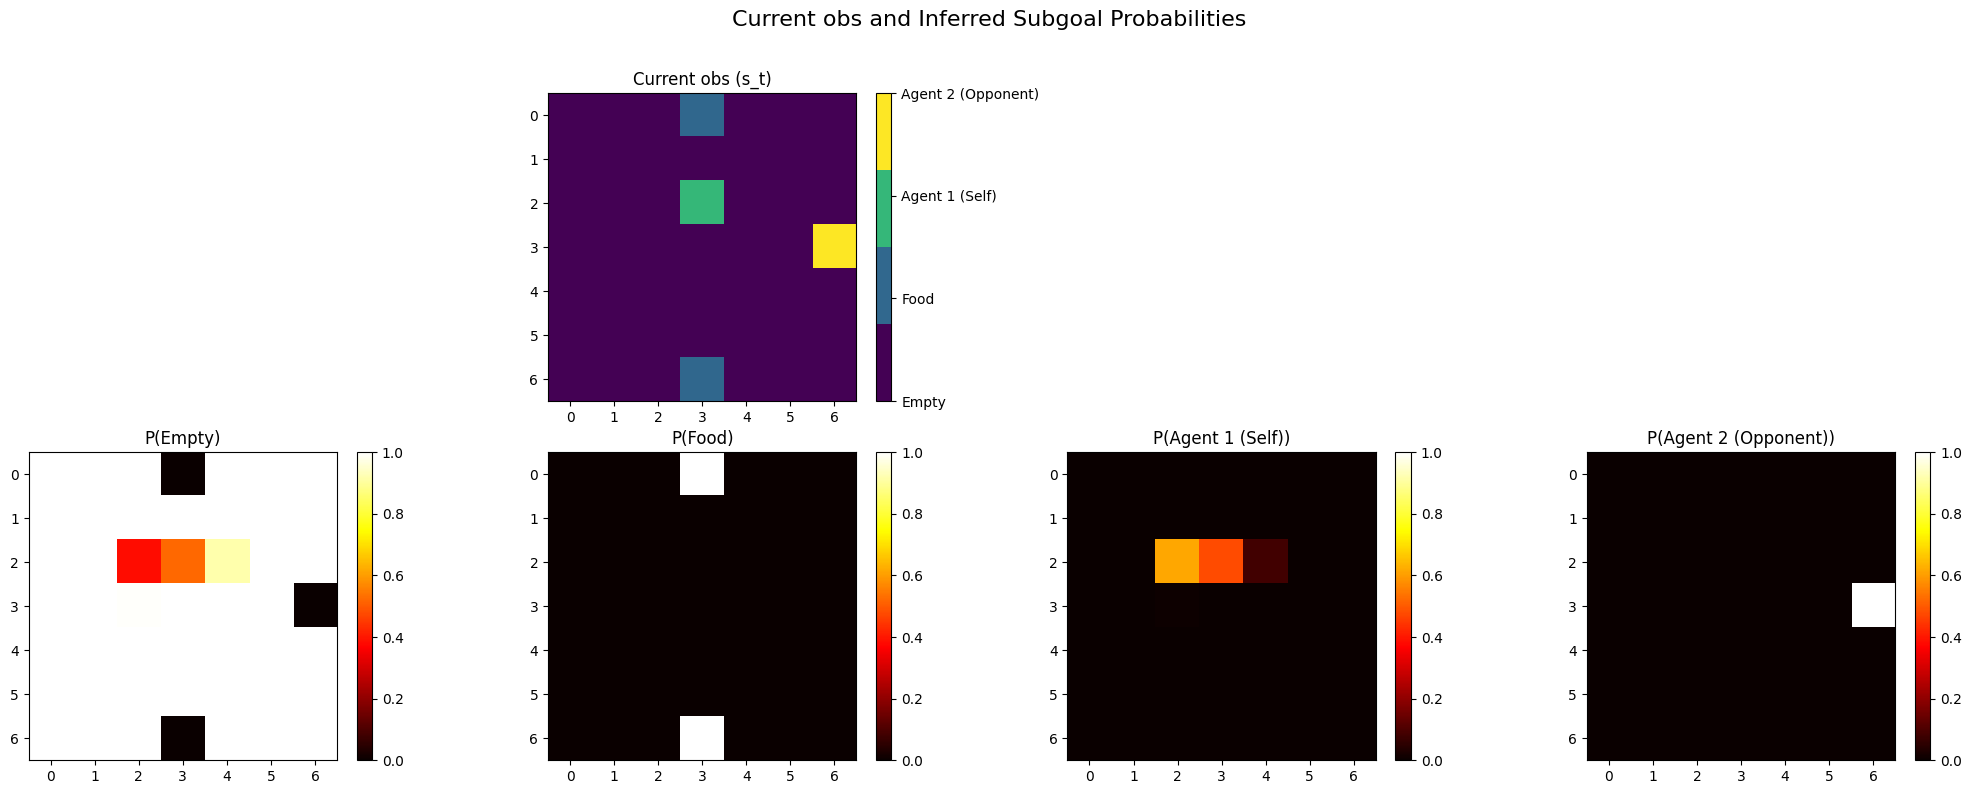

[ 5.48482165e-02 -3.37643921e-02  1.38255835e-01  4.51757908e-02
 -1.33274570e-02 -6.16269745e-03  3.47397178e-02  6.99357837e-02
 -7.25766718e-02  2.05756724e-03 -8.73979926e-03  1.58324313e+00
 -8.76972616e-01 -2.78635398e-02 -1.48320127e+00 -3.74697894e-02
 -5.41105866e-04 -1.25027820e-03 -1.29196435e-01  4.76354063e-02
  1.03876144e-02  8.76544714e-02  6.47414625e-02 -1.74368620e-02
 -1.12321377e-01 -3.02388072e-02 -1.16684176e-02  1.84928775e-02
 -1.72903389e-03 -3.28230858e-02 -1.50414705e-02 -3.58852744e-03]


In [16]:
env._place_agent(0, (2, 3))
obs = env._get_observations()
op_model.prior_model.eval()
recon_logits, mu, logvar = op_model.prior_model(
    torch.from_numpy(obs[0]).float().unsqueeze(0).to(args.device)
)
op_model.visualize_subgoal_logits(
    obs[0], recon_logits)
print(mu.squeeze(0).detach().cpu().numpy())